In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, floor
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, IndexToString, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.types import DoubleType
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder\
    .appName("Classification RandomForest")\
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .enableHiveSupport()\
    .getOrCreate()

spark.sparkContext.setLogLevel("OFF")
spark.catalog.clearCache()
spark.sql("USE concessionnaire")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/20 13:47:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


DataFrame[]

In [3]:
clients_immatriculations = spark.sql("SELECT * FROM clients_immatriculations")
clients_immatriculations.printSchema()

root
 |-- immatriculation: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: double (nullable = true)
 |-- situationfamiliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: boolean (nullable = true)
 |-- taux_eligible: boolean (nullable = true)
 |-- marque: string (nullable = true)
 |-- modele: string (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- longueur: string (nullable = true)
 |-- nbplaces: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- couleur: string (nullable = true)
 |-- occasion: boolean (nullable = true)
 |-- prix: integer (nullable = true)
 |-- categorie: string (nullable = true)



### Verification des doublons

In [4]:
doublons = clients_immatriculations.groupBy(*clients_immatriculations.columns).agg(count("*").alias("count")).filter("count > 1")
doublons.show(truncate=False)

+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+
|immatriculation|age|sexe|taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|categorie|count|
+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+
+---------------+---+----+----+------------------+---------------+---------------+-------------+------+------+---------+--------+--------+--------+-------+--------+----+---------+-----+



### Analyse des **null**

In [5]:
doublons = clients_immatriculations.groupBy('nbenfantacharge').count().show()

+---------------+-----+
|nbenfantacharge|count|
+---------------+-----+
|              1|16425|
|              3|11451|
|              4| 9960|
|              2|16592|
|              0|44973|
+---------------+-----+



### Supprimer les colones inutiles

In [6]:
clients_immatriculations = clients_immatriculations.drop('immatriculation')
clients_immatriculations = clients_immatriculations.drop('couleur')
clients_immatriculations = clients_immatriculations.drop('marque')

clients_immatriculations.show()

+----+----+------+------------------+---------------+---------------+-------------+----------------+---------+-----------+--------+--------+--------+------+---------+
| age|sexe|  taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|          modele|puissance|   longueur|nbplaces|nbportes|occasion|  prix|categorie|
+----+----+------+------------------+---------------+---------------+-------------+----------------+---------+-----------+--------+--------+--------+------+---------+
|61.0|   M| 188.0|       celibataire|              0|          false|        false|     picanto 1.1|       65|     courte|       5|       5|   false|  8990| citadine|
|50.0|   F| 460.0|         en couple|              3|          false|        false|vel satis 3.5 v6|      245|tres longue|       5|       5|   false| 49200|      SUV|
|54.0|   M| 403.0|       celibataire|              0|          false|        false|     polo 1.2 6v|       55|     courte|       5|       3|   false| 12200| citadine

In [7]:

# clients_immatriculations = clients_immatriculations.withColumn(
#     "age_group",
#     when(col("age") < 26, 0)
#     .when((col("age") >= 26) & (col("age") <= 35), 1)
#     .when((col("age") >= 36) & (col("age") <= 50), 2)
#     .otherwise(3)
# )


# clients_immatriculations = clients_immatriculations.withColumn(
#     "nbenfantacharge_grouped",
#     when(col("nbenfantacharge") >= 2, 1).otherwise(0)
# )


# clients_immatriculations = clients_immatriculations.withColumn("taux_par_enfant", col("taux") / (col("nbenfantacharge") + 1))
# clients_immatriculations = clients_immatriculations.withColumn("age_taux_ratio", col("age") / (col("taux") + 1))
# clients_immatriculations = clients_immatriculations.withColumn("deuxieme_voiture_taux", col("deuxiemevoiture") * col("taux"))

### OneHotEncoder

In [8]:
indexer_sexe = StringIndexer(inputCol="sexe", outputCol="sexe_index").fit(clients_immatriculations)
clients_immatriculations = indexer_sexe.transform(clients_immatriculations)

encoder_sexe = OneHotEncoder(inputCol="sexe_index", outputCol="sexe_encoded").fit(clients_immatriculations)
clients_immatriculations = encoder_sexe.transform(clients_immatriculations)

In [9]:
indexer_situationfamiliale = StringIndexer(inputCol="situationfamiliale", outputCol="situationfamiliale_index").fit(clients_immatriculations)
clients_immatriculations = indexer_situationfamiliale.transform(clients_immatriculations)

encoder_situationfamiliale = OneHotEncoder(inputCol="situationfamiliale_index", outputCol="situationfamiliale_encoded").fit(clients_immatriculations)
clients_immatriculations = encoder_situationfamiliale.transform(clients_immatriculations)

In [10]:
clients_immatriculations = clients_immatriculations.drop('puissance')
clients_immatriculations = clients_immatriculations.drop('nbportes')
clients_immatriculations = clients_immatriculations.drop('occasion')
clients_immatriculations = clients_immatriculations.drop('prix')
clients_immatriculations = clients_immatriculations.drop('nbplaces') 
clients_immatriculations = clients_immatriculations.drop('modele') 
clients_immatriculations = clients_immatriculations.drop('longueur')

## Changer des Boolean en Int

In [11]:
clients_immatriculations = clients_immatriculations.withColumn(
    "deuxiemevoiture",
    when(col("deuxiemevoiture") == False, 0)
    .when(col("deuxiemevoiture") == True, 1)
    .otherwise(col("deuxiemevoiture").cast("int"))
)

clients_immatriculations = clients_immatriculations.withColumn(
    "taux_eligible",
    when(col("taux_eligible") == False, 0)
    .when(col("taux_eligible") == True, 1)
    .otherwise(col("taux_eligible").cast("int"))
)

clients_immatriculations.show(4)

+----+----+-----+------------------+---------------+---------------+-------------+---------+----------+-------------+------------------------+--------------------------+
| age|sexe| taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|categorie|sexe_index| sexe_encoded|situationfamiliale_index|situationfamiliale_encoded|
+----+----+-----+------------------+---------------+---------------+-------------+---------+----------+-------------+------------------------+--------------------------+
|61.0|   M|188.0|       celibataire|              0|              0|            0| citadine|       0.0|(1,[0],[1.0])|                     1.0|             (3,[1],[1.0])|
|50.0|   F|460.0|         en couple|              3|              0|            0|      SUV|       1.0|    (1,[],[])|                     0.0|             (3,[0],[1.0])|
|54.0|   M|403.0|       celibataire|              0|              0|            0| citadine|       0.0|(1,[0],[1.0])|                     1.0|        

## Normalisation

In [12]:
clients_immatriculations.groupBy("categorie").count().show()

+---------+-----+
|categorie|count|
+---------+-----+
| citadine|35715|
|  berline| 8163|
|      SUV|28314|
| compacte| 8330|
|    break|18879|
+---------+-----+



In [13]:
clients_immatriculations.printSchema()
clients_immatriculations.show()

root
 |-- age: double (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: double (nullable = true)
 |-- situationfamiliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: integer (nullable = true)
 |-- taux_eligible: integer (nullable = true)
 |-- categorie: string (nullable = true)
 |-- sexe_index: double (nullable = false)
 |-- sexe_encoded: vector (nullable = true)
 |-- situationfamiliale_index: double (nullable = false)
 |-- situationfamiliale_encoded: vector (nullable = true)

+----+----+------+------------------+---------------+---------------+-------------+---------+----------+-------------+------------------------+--------------------------+
| age|sexe|  taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|categorie|sexe_index| sexe_encoded|situationfamiliale_index|situationfamiliale_encoded|
+----+----+------+------------------+---------------+---------------+-------------+---------+----------+------

## Classificateur

In [15]:
# Apprentissage des labels
indexer_model = StringIndexer(inputCol="categorie", outputCol="label").fit(clients_immatriculations)

clients_immatriculations = indexer_model.transform(clients_immatriculations)

In [16]:
feature_cols = [col for col in clients_immatriculations.columns if col not in ["categorie", "label", 'sexe', 'situationfamiliale']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(clients_immatriculations).select("features", "label")

Index(['age', 'sexe', 'taux', 'situationfamiliale', 'nbenfantacharge',
       'deuxiemevoiture', 'taux_eligible', 'categorie', 'sexe_index',
       'sexe_encoded', 'situationfamiliale_index',
       'situationfamiliale_encoded', 'label'],
      dtype='object')


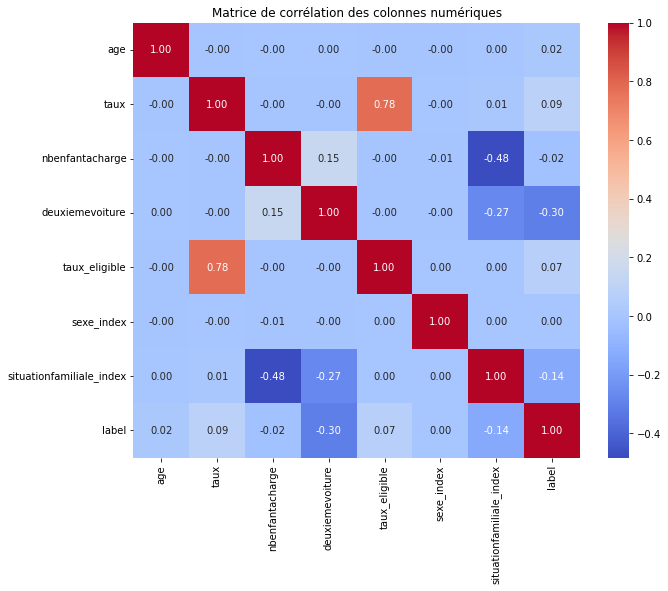

In [17]:
# Convertir le DataFrame PySpark en DataFrame Pandas
clients_pd = clients_immatriculations.toPandas()

print(clients_pd.columns)

# Garder uniquement les colonnes numériques pour la corrélation
numeric_columns = clients_pd.columns
numeric_data = clients_pd[numeric_columns]

# Calcul de la matrice de corrélation
correlation_matrix = numeric_data.corr()

# Tracer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des colonnes numériques")
plt.show()

In [18]:
# Diviser les données en 60% entraînement, 20% validation et 20% test
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=42)

print(f"Taille de l'ensemble d'entraînement : {trainingData.count()}")
# print(f"Taille de l'ensemble de validation : {validationData.count()}")
print(f"Taille de l'ensemble de test : {testData.count()}")


Taille de l'ensemble d'entraînement : 79795


Taille de l'ensemble de test : 19606


In [19]:
# Définir les hyperparamètres à tester
param_grid = {
    'numTrees': [10, 20, 50],
    'maxDepth': [5, 10, 15],
    'maxBins': [32, 64]
}

# Liste pour enregistrer les résultats
results = []

# Générer toutes les combinaisons d'hyperparamètres
for numTrees, maxDepth, maxBins in product(param_grid['numTrees'], param_grid['maxDepth'], param_grid['maxBins']):
    # Configurer le modèle avec les hyperparamètres
    rf = RandomForestClassifier(numTrees=numTrees, maxDepth=maxDepth, maxBins=maxBins, labelCol="label", featuresCol="features")
    
    # Entraîner le modèle
    model = rf.fit(trainingData)
    
    # Prédire sur les données de test
    predictions = model.transform(testData)
    
    # Évaluer la précision
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(predictions)
    
    # Enregistrer les résultats
    results.append((numTrees, maxDepth, maxBins, f1_score))

# Trouver les meilleurs hyperparamètres
best_params = max(results, key=lambda x: x[3])  # Trier par précision
print(f"Meilleurs paramètres : numTrees={best_params[0]}, maxDepth={best_params[1]}, maxBins={best_params[2]} avec précision={best_params[3]}")

Meilleurs paramètres : numTrees=10, maxDepth=15, maxBins=64 avec précision=0.7370453737987723


## Prediction de marketing

In [22]:
df_marketing = spark.sql("SELECT * FROM marketing")
df_marketing.printSchema()


df_marketing = indexer_sexe.transform(df_marketing)
df_marketing = encoder_sexe.transform(df_marketing)
df_marketing.show()


df_marketing = indexer_situationfamiliale.transform(df_marketing)
df_marketing = encoder_situationfamiliale.transform(df_marketing)
df_marketing = df_marketing.withColumn(
    "deuxiemevoiture",
    when(col("deuxiemevoiture") == False, 0)
    .when(col("deuxiemevoiture") == True, 1)
    .otherwise(col("deuxiemevoiture").cast("int"))
)

df_marketing = df_marketing.withColumn(
    "taux_eligible",
    when(col("taux_eligible") == False, 0)
    .when(col("taux_eligible") == True, 1)
    .otherwise(col("taux_eligible").cast("int"))
)
df_marketing = df_marketing.select(feature_cols)

# Assembler les caractéristiques
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
prediction_data = assembler.transform(df_marketing).select("features")

# Effectuer les prédictions
marketingPrediction = model.transform(prediction_data)

# Mapper les prédictions avec les labels
label_to_category = IndexToString(
    inputCol="prediction",
    outputCol="predicted_category",
    labels=indexer_model.labels
)
result = label_to_category.transform(marketingPrediction)

# Afficher les résultats
result.show()

root
 |-- age: integer (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: float (nullable = true)
 |-- situationfamiliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: boolean (nullable = true)
 |-- taux_eligible: boolean (nullable = true)

+---+----+------+------------------+---------------+---------------+-------------+----------+-------------+
|age|sexe|  taux|situationfamiliale|nbenfantacharge|deuxiemevoiture|taux_eligible|sexe_index| sexe_encoded|
+---+----+------+------------------+---------------+---------------+-------------+----------+-------------+
| 21|   F|1396.0|       celibataire|              0|          false|        false|       1.0|    (1,[],[])|
| 35|   M| 223.0|       celibataire|              0|          false|         true|       0.0|(1,[0],[1.0])|
| 48|   M| 401.0|       celibataire|              0|          false|         true|       0.0|(1,[0],[1.0])|
| 26|   F| 420.0|         en couple|           